In [13]:
import pandas as pd
import tensorflow as tf
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input,GlobalAveragePooling1D
from keras import optimizers
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime, timedelta
import math

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2846767335242127738
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13309057598457145161
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [15]:
timestep = 100
testfrac = 0.2
valfrac = 0.25

In [23]:
start_date = '2010-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("AAPL", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dataclose = data['Close']

'2024-01-19'

[*********************100%%**********************]  1 of 1 completed


In [24]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
display(data)

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800
...,...,...,...,...,...
3529,186.539993,187.050003,183.619995,185.589996,49128400
3530,186.059998,186.740005,185.190002,185.919998,40444700
3531,182.160004,184.259995,180.929993,183.630005,65603000
3532,181.270004,182.929993,180.300003,182.679993,47317400


In [26]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data))
Yscaler = MinMaxScaler()
Ydata = Yscaler.fit_transform(np.array([data['Close']]).transpose()).reshape((Xdata.shape[0],))
display(Xdata.shape)
display(Ydata.shape)

(3534, 5)

(3534,)

In [27]:
X_temp, X_test = train_test_split(Xdata, test_size=testfrac, shuffle=False)
Y_temp, Y_test = train_test_split(Ydata, test_size=testfrac, shuffle=False)
X_train, X_val = train_test_split(X_temp, test_size=valfrac, shuffle=False)
Y_train, Y_val = train_test_split(Y_temp, test_size=valfrac, shuffle=False)


In [28]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((Ydata.shape[0] - time_step,))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [29]:
X_train, Y_train = build_timeseries(X_train, Y_train, timestep)
X_test, Y_test = build_timeseries(X_test, Y_test, timestep)
X_val, Y_val = build_timeseries(X_val, Y_val, timestep)
print("X Train Shape: ", X_train.shape, "   Y Train Shape: ", Y_train.shape)
print("X Val Shape: ", X_val.shape, "   Y Val Shape: ", Y_val.shape)
print("X Test Shape: ", X_test.shape, "   Y Test Shape: ", Y_test.shape)

X Train Shape:  (2020, 100, 5)    Y Train Shape:  (2020,)
X Val Shape:  (607, 100, 5)    Y Val Shape:  (607,)
X Test Shape:  (607, 100, 5)    Y Test Shape:  (607,)


In [30]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)

(2020, 100, 5)

(607, 100, 5)

(607, 100, 5)

In [31]:
def model_builder(hp):
    lstm_model = Sequential()
    
    lstm_units_0 = hp.Int('units_lstm_0', min_value=16, max_value=256, step=16)
    lstm_units_1 = hp.Int('units_lstm_1', min_value=16, max_value=256, step=16)
    lstm_units_2 = hp.Int('units_lstm_2', min_value=16, max_value=256, step=16)
    dense_units_0 = hp.Int('units_dense_0', min_value=16, max_value=256, step=16)
    dense_units_1 = hp.Int('units_dense_1', min_value=16, max_value=256, step=16)
    dense_units_2 = hp.Int('units_dense_2', min_value=16, max_value=256, step=16)
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(LSTM(units=lstm_units_0, return_sequences=True, kernel_initializer='he_normal'))
    lstm_model.add(LSTM(units=lstm_units_1, return_sequences=True))
    lstm_model.add(LSTM(units=lstm_units_2, return_sequences=True))
    lstm_model.add(GlobalAveragePooling1D())
    lstm_model.add(Dense(units=dense_units_0,activation='relu'))
    lstm_model.add(Dense(units=dense_units_1,activation='relu'))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Dense(units=dense_units_2, activation='linear'))
    lstm_model.add(Dense(units=1))
    lstm_model.summary()
    
    hyperparameters_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.05, 0.1])
    
    lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hyperparameters_learning_rate))
    
    return lstm_model

In [13]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=50)
tuner.search(X_train, Y_train, epochs=25, validation_data=(X_val,Y_val))
lstm_model  = tuner.get_best_models()[0]  
print(lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Trial 50 Complete [00h 00m 37s]
val_loss: 0.05100097134709358

Best val_loss So Far: 0.018898727372288704
Total elapsed time: 00h 28m 43s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 224)           206080    
                                                                 
 lstm_1 (LSTM)               (None, 25, 256)           492544    
                                                                 
 lstm_2 (LSTM)               (None, 25, 160)           266880    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               20608     
                                                  

In [14]:
lstm_model.save("AAPL_LSTM.keras")

In [15]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 224)           206080    
                                                                 
 lstm_1 (LSTM)               (None, 25, 256)           492544    
                                                                 
 lstm_2 (LSTM)               (None, 25, 160)           266880    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               20608     
                                                                 
 dense_1 (Dense)             (None, 208)               26832     
                                                        

In [16]:
lstm_model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 50,batch_size = 64,verbose = 1)

Epoch 1/50
33/33 [==============================] - 5s 45ms/step - loss: 0.0011 - val_loss: 0.0209
Epoch 2/50
33/33 [==============================] - 1s 20ms/step - loss: 9.4141e-04 - val_loss: 0.0153
Epoch 3/50
33/33 [==============================] - 1s 18ms/step - loss: 6.4326e-04 - val_loss: 0.0231
Epoch 4/50
33/33 [==============================] - 1s 21ms/step - loss: 6.2311e-04 - val_loss: 0.0234
Epoch 5/50
33/33 [==============================] - 1s 19ms/step - loss: 5.7725e-04 - val_loss: 0.0204
Epoch 6/50
33/33 [==============================] - 1s 20ms/step - loss: 5.6900e-04 - val_loss: 0.0237
Epoch 7/50
33/33 [==============================] - 1s 20ms/step - loss: 5.5347e-04 - val_loss: 0.0202
Epoch 8/50
33/33 [==============================] - 1s 21ms/step - loss: 3.7264e-04 - val_loss: 0.0180
Epoch 9/50
33/33 [==============================] - 1s 19ms/step - loss: 4.6785e-04 - val_loss: 0.0282
Epoch 10/50
33/33 [==============================] - 1s 20ms/step - loss: 4.0

In [24]:
train_predict = lstm_model.predict(X_train)
val_predict = lstm_model.predict(X_val)
test_predict = lstm_model.predict(X_test)
train_predictraw = Yscaler.inverse_transform(train_predict)
val_predictraw = Yscaler.inverse_transform(val_predict)
test_predictraw = Yscaler.inverse_transform(test_predict)

22/22 [==============================] - 0s 5ms/step


In [26]:
print(Y_test.shape)
print(test_predictraw.shape)

(702,)
(702,)


In [27]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)) / Y_train.shape[0])
print(math.sqrt(mean_squared_error(Y_val,val_predict)) / Y_val.shape[0])
print(math.sqrt(mean_squared_error(Y_test,test_predict)) / Y_test.shape[0])

3.6041629663348426e-06
0.00020553603376024328
0.0006597879157708907


In [51]:
display(dataclose)
display(pd.DataFrame(test_predictraw))

0         7.643214
1         7.656429
2         7.534643
3         7.520714
4         7.570714
           ...    
3529    185.589996
3530    185.919998
3531    183.630005
3532    182.679993
3533    188.630005
Name: Close, Length: 3534, dtype: float64

,0
0,70.1250
1,70.1250
2,70.0625
3,70.1250
4,70.0625
...,...
697,74.9375
698,74.9375
699,74.8750
700,74.8750


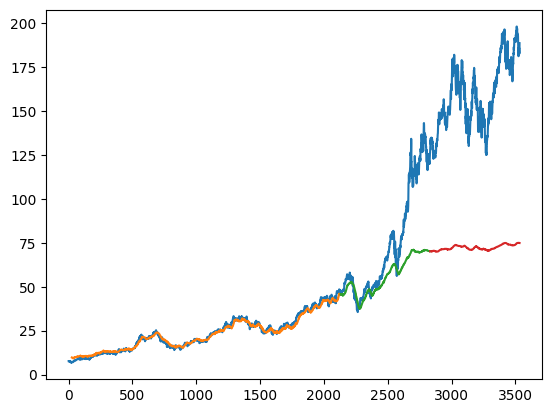

In [50]:
plt.plot(dataclose)

trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot.fill(np.nan)
trainPredictPlot[timestep:len(train_predictraw)+timestep:] = train_predictraw
plt.plot(trainPredictPlot)

valPredictPlot = np.empty_like(dataclose)
valPredictPlot.fill(np.nan)
valPredictPlot[len(train_predictraw)+timestep*2:len(train_predictraw)+timestep*2+len(val_predictraw):] = val_predictraw
plt.plot(valPredictPlot)

testPredictPlot = np.empty_like(dataclose)
testPredictPlot.fill(np.nan)
testPredictPlot[len(train_predictraw)+timestep*3+len(val_predictraw):len(train_predictraw)+timestep*3+len(val_predictraw)+len(test_predictraw):] = test_predictraw
plt.plot(testPredictPlot)

plt.show()